In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ ARIMA forecast

In [2]:
"""
!pip install yfinance
!pip install finta
!pip install chart_studio
!pip install holidays
!pip install pmdarima
!pip install statsmodels --upgrade
"""

'\n!pip install yfinance\n!pip install finta\n!pip install chart_studio\n!pip install holidays\n!pip install pmdarima\n!pip install statsmodels --upgrade\n'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

import yfinance as yf
import datetime
import holidays
from finta import TA

import chart_studio.plotly as py
from plotly.graph_objs import * 
import plotly.tools as tls
import chart_studio.tools as ctls

from pandas.plotting import lag_plot
import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

import logging

logging.getLogger().setLevel(logging.ERROR)

import plotly.express as px

# Import/Download Data

In [4]:
"""
Defining some constants for data mining
"""

NUM_DAYS = 10000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'V'     # Symbol of the desired stock

# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'BASP', 'PIVOT_FIB', 'VORTEX']

"""
Pull the historical data using yfinance
Rename the column names because finta uses the lowercase names
"""

start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
end = datetime.datetime.today()

df = yf.download(symbol, start=start, end=end, interval=INTERVAL)
df.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
df.tail()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,Adj Close,volume
Date,,,,,,
2022-06-13,192.990005,195.889999,191.080002,192.259995,192.259995,7119200
2022-06-14,192.720001,194.339996,191.750000,193.520004,193.520004,6441200
2022-06-15,195.979996,198.830002,192.229996,196.160004,196.160004,6490000
2022-06-16,191.410004,191.869995,187.529999,189.050003,189.050003,9887200
2022-06-17,186.929993,191.309998,185.910004,190.009995,190.009995,15087700


<AxesSubplot:title={'center':'Price for last 60days of V'}, xlabel='Date', ylabel='Price'>

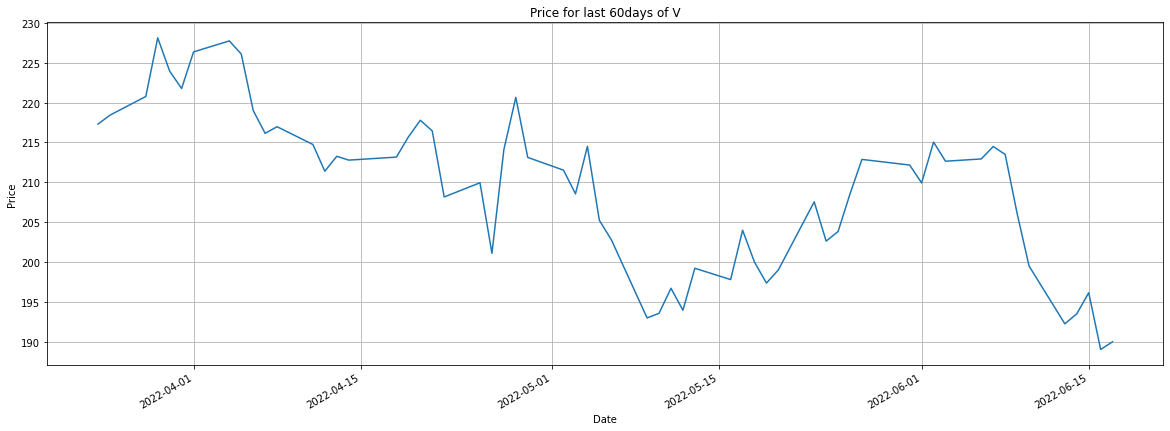

In [5]:
#preview last 60 days
plt.figure(figsize=(20,7))
wmt_prev = df.iloc[-60:]
wmt_prev['close'].plot(title = f"Price for last 60days of {symbol}", ylabel = "Price", grid = True)

In [6]:
df_copy = df.copy()

In [7]:
df

,open,high,low,close,Adj Close,volume
Date,,,,,,
2008-03-19,14.875000,17.250000,13.750000,14.125000,12.803708,708486000
2008-03-20,14.600000,16.250000,14.375000,16.087500,14.582631,198985200
2008-03-24,16.809999,16.924999,14.750000,14.932500,13.535672,149566400
2008-03-25,15.145000,16.062500,14.955000,15.812500,14.333352,87092000
2008-03-26,15.682500,16.120001,15.392500,15.990000,14.494256,43111600
...,...,...,...,...,...,...
2022-06-13,192.990005,195.889999,191.080002,192.259995,192.259995,7119200
2022-06-14,192.720001,194.339996,191.750000,193.520004,193.520004,6441200
2022-06-15,195.979996,198.830002,192.229996,196.160004,196.160004,6490000


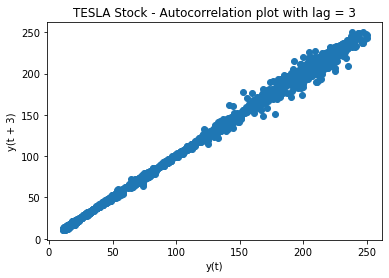

In [8]:
plt.figure()
lag_plot(df['open'], lag=3)
plt.title('TESLA Stock - Autocorrelation plot with lag = 3')
plt.show()

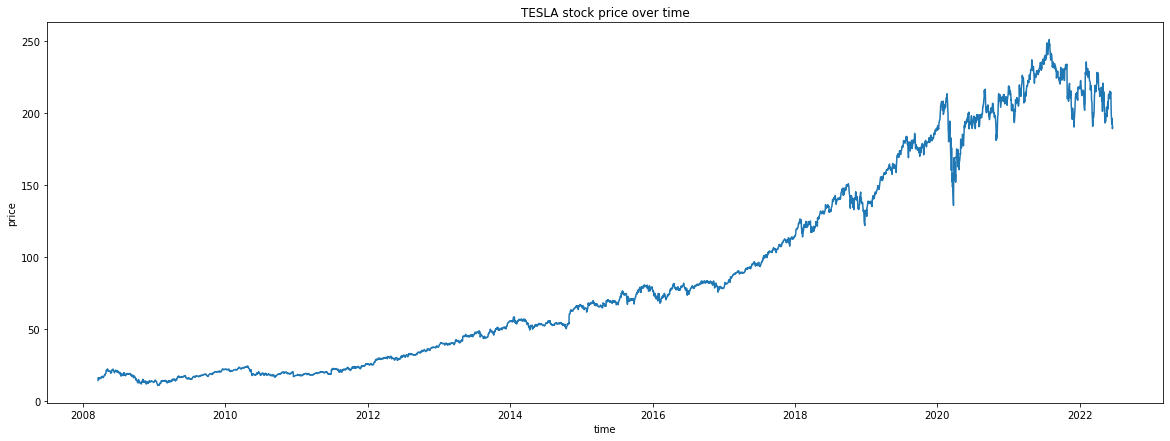

In [9]:
plt.figure(figsize=(20,7))
plt.plot(df.index, df["close"])
#plt.xticks(np.arange(0,1259, 200), df.index[0:1259:200])
plt.title("TESLA stock price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

# ARIMA MODEL

In [10]:
#silence annoying warnings
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)



#split dataset
train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]
training_data = train_data['close'].values
test_data = test_data['close'].values

#Build model
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(alpha = 0.05)
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
    
#Evaluate
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))
print(model_fit.summary())

C:\Users\RaimiAzeez\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




Testing Mean Squared Error is 11.887525330808302
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3587
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -7502.859
Method:                       css-mle   S.D. of innovations              1.960
Date:                Tue, 21 Jun 2022   AIC                          15017.719
Time:                        14:28:01   BIC                          15054.829
Sample:                             1   HQIC                         15030.947
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0490      0.028      1.750      0.080      -0.006       0.104
ar.L1.D.y     -0.1131      0.017     -6.777      0.000      -0.146      -0.080
ar.

In [11]:
#silence annoying warnings
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)


#split dataset
train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]
training_data = train_data['close'].values
test_data = test_data['close'].values

#Build model
history = [x for x in training_data]
model_predictions = []
lower = []
upper = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output, se, conf = model_fit.forecast(alpha = 0.05)
    yhat = output
    low = conf[:,0]
    up = conf[:,1]
    model_predictions.append(yhat)
    lower.append(low)
    upper.append(up)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
    
#Evaluate
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))
print(model_fit.summary())

C:\Users\RaimiAzeez\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




Testing Mean Squared Error is 11.887525330808302
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3587
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -7502.859
Method:                       css-mle   S.D. of innovations              1.960
Date:                Tue, 21 Jun 2022   AIC                          15017.719
Time:                        14:30:45   BIC                          15054.829
Sample:                             1   HQIC                         15030.947
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0490      0.028      1.750      0.080      -0.006       0.104
ar.L1.D.y     -0.1131      0.017     -6.777      0.000      -0.146      -0.080
ar.

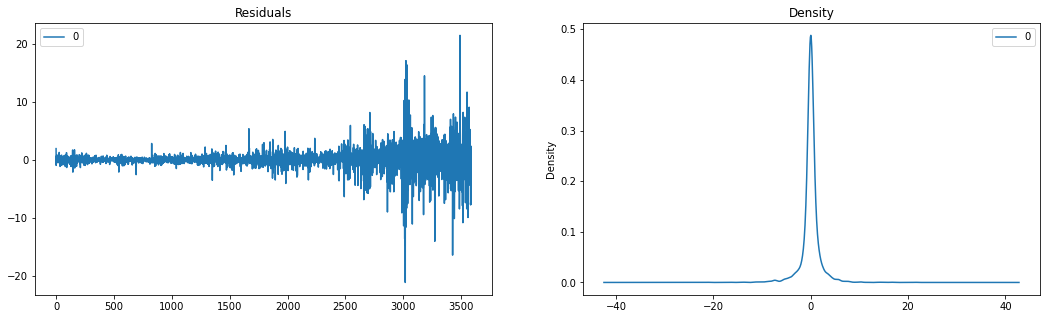

In [12]:
# Plot residual errors

residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(18,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [13]:
li = [float(i) for i in model_predictions]
low = [float(i) for i in lower]
up = [float(i) for i in upper]


td = pd.DataFrame(test_data, columns = ["Price"])
td["Predictions"] = li
td["Lower"] = low
td["Upper"] = up
td['Predictions'] = td['Predictions'].shift(-1)
td['Lower'] = td['Lower'].shift(-1)
td['Upper'] = td['Upper'].shift(-1)


td

,Price,Predictions,Lower,Upper
0,124.239998,124.080487,122.684549,125.476424
1,123.199997,123.371729,121.975647,124.767810
2,122.580002,122.730980,121.334835,124.127125
3,123.410004,123.455957,122.059838,124.852075
4,124.529999,124.431322,123.034852,125.827792
...,...,...,...,...
1072,192.259995,193.153134,189.319380,196.986887
1073,193.520004,193.859569,190.026332,197.692806
1074,196.160004,196.576736,192.743304,200.410169
1075,189.050003,190.427558,186.586822,194.268294


In [14]:
#forcast last day
#history = [x for x in training_data]
test_model_predictions = []
N_test_observations = len(test_data)
model = ARIMA(df.close.values, order=(4,1,0))
model_fit = model.fit(disp=0)
output, se, conf = model_fit.forecast(alpha = 0.05)
yhat = output
low = conf[:,0]
up = conf[:,1]

yhat = [float(i) for i in yhat]
low = [float(i) for i in low]
up = [float(i) for i in up]

td.Predictions.values[-1] = yhat[0]
td.Lower.values[-1] = low[0]
td.Upper.values[-1] = up[0]

td

C:\Users\RaimiAzeez\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




,Price,Predictions,Lower,Upper
0,124.239998,124.080487,122.684549,125.476424
1,123.199997,123.371729,121.975647,124.767810
2,122.580002,122.730980,121.334835,124.127125
3,123.410004,123.455957,122.059838,124.852075
4,124.529999,124.431322,123.034852,125.827792
...,...,...,...,...
1072,192.259995,193.153134,189.319380,196.986887
1073,193.520004,193.859569,190.026332,197.692806
1074,196.160004,196.576736,192.743304,200.410169
1075,189.050003,190.427558,186.586822,194.268294


In [15]:
td

,Price,Predictions,Lower,Upper
0,124.239998,124.080487,122.684549,125.476424
1,123.199997,123.371729,121.975647,124.767810
2,122.580002,122.730980,121.334835,124.127125
3,123.410004,123.455957,122.059838,124.852075
4,124.529999,124.431322,123.034852,125.827792
...,...,...,...,...
1072,192.259995,193.153134,189.319380,196.986887
1073,193.520004,193.859569,190.026332,197.692806
1074,196.160004,196.576736,192.743304,200.410169
1075,189.050003,190.427558,186.586822,194.268294


In [16]:
result = pd.DataFrame(model_predictions, index = df[int(len(df)*0.7):].index, columns = ['Forecast'])
result["Actual"] = test_data
lo = [float(i) for i in lower]
upp = [float(i) for i in upper]

result["Lower"] = lo
result["Upper"] = upp
results = result[-50:]

td_ = td[-50:]

plt.figure(figsize=(20,7))
plt.plot(test_set_range, td.Predictions.values, color='blue',  marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, td.Price.values, color='red', label='Actual Price')
plt.fill_between(test_set_range, td.Lower.values, td.Upper.values, color='k', alpha=.15)
#plt.plot(td)
plt.title(f'{symbol} Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
#plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.show()

NameError: name 'test_set_range' is not defined

<Figure size 1440x504 with 0 Axes>

In [20]:
td_ = td[-50:]

plt.figure(figsize=(20,7))
plt.plot(test_set_range[-50:], td_.Predictions.values, color='blue',  marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range[-50:], td_.Price.values, color='red', label='Actual Price')
plt.fill_between(test_set_range[-50:], td_.Lower.values, td_.Upper.values, color='k', alpha=.15)
#plt.plot(td)
plt.title(f'{symbol} last 50 Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
#plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.show()

NameError: name 'test_set_range' is not defined

<Figure size 1440x504 with 0 Axes>

In [21]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    #corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'minmax':minmax})

forecast_accuracy(td.Predictions.values, td.Price.values)


{'mape': 0.0021709724414152687,
 'me': 0.04818288311702759,
 'mae': 0.40552601971366115,
 'mpe': 0.00028370811425440707,
 'rmse': 0.6317938383251247,
 'minmax': 0.0021643431108534505}

In [22]:
#forcast next day
#history = [x for x in training_data]
next_model_predictions = []
N_test_observations = len(td)
model = ARIMA(td.Predictions.values, order=(4,1,0))
model_fit = model.fit(disp=0)
output = model_fit.forecast()
yhat_ = output[0]
yhat_

array([189.46314561])

# AUTO-ARIMA

In [27]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

pmodel = pm.auto_arima(df.close, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(pmodel.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15032.331, Time=2.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15079.047, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15032.750, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15035.602, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15079.252, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15034.011, Time=2.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15033.824, Time=1.91 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15032.818, Time=0.80 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15032.089, Time=0.45 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=15033.633, Time=0.80 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15009.569, Time=5.33 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=14959.007, Time=5.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=15020.947, Time=1.80 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=14957.373, Time=4.85 sec
 ARIMA(5,1,0)(0,0,0

C:\Users\RaimiAzeez\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3558
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -7307.630
Method:                       css-mle   S.D. of innovations              1.887
Date:                Tue, 21 Jun 2022   AIC                          14635.261
Time:                        14:43:50   BIC                          14697.030
Sample:                             1   HQIC                         14657.287
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0552      0.015      3.746      0.000       0.026       0.084
ar.L1.D.y     -0.5618      1.945     -0.289      0.773      -4.375       3.251
ar.L2.D.y      0.9565      1.593      0.600      0.5

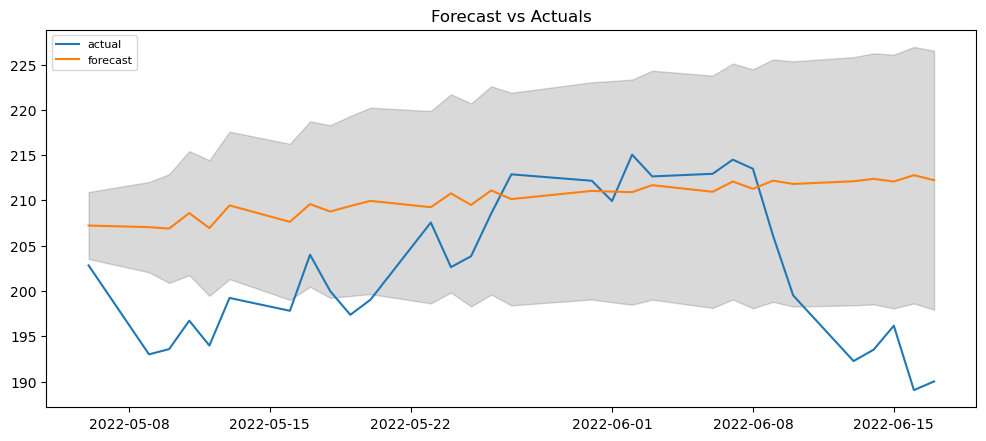

,Forecast,Actual,Lower,Upper
Date,,,,
2022-06-06,210.954619,212.940002,198.124635,223.784604
2022-06-07,212.088469,214.500000,199.059161,225.117777
2022-06-08,211.282462,213.500000,198.083763,224.481161
2022-06-09,212.181284,206.110001,198.798742,225.563825
2022-06-10,211.819810,199.509995,198.277477,225.362143
2022-06-13,212.113863,192.259995,198.405902,225.821823
2022-06-14,212.379472,193.520004,198.516262,226.242681
2022-06-15,212.086623,196.160004,198.074703,226.098542
2022-06-16,212.786732,189.050003,198.623585,226.949880


In [24]:
from statsmodels.tsa.stattools import acf
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)

# Create Training and Test
split = 30
train, test = df.close[:(len(df) - split)], df.close[-split:]


# Build Model
model = ARIMA(train.values.reshape(-1).tolist(), order=(4,1,4))  
#model = ARIMA(train.values.reshape(-1).tolist(), order=(0, 1, 0))  
fitted = model.fit(disp=-1) 
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index = test.index)
lower_series = pd.Series(conf[:, 0], index = test.index)
upper_series = pd.Series(conf[:, 1], index = test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

result = pd.DataFrame(fc_series, index = test.index, columns = ['Forecast'])
result["Actual"] = test.values
result["Lower"] = lower_series
result["Upper"] = upper_series
result.tail(10)

In [25]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)


C:\Users\RaimiAzeez\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Users\RaimiAzeez\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



{'mape': 0.04534229092857319,
 'me': 7.8822446864526565,
 'mae': 8.920083913406216,
 'mpe': 0.04048652619428996,
 'rmse': 11.068923070266534,
 'acf1': 0.7749811650509033,
 'corr': 0.20949216606296103,
 'minmax': 0.04237993427254061}

C:\Users\RaimiAzeez\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



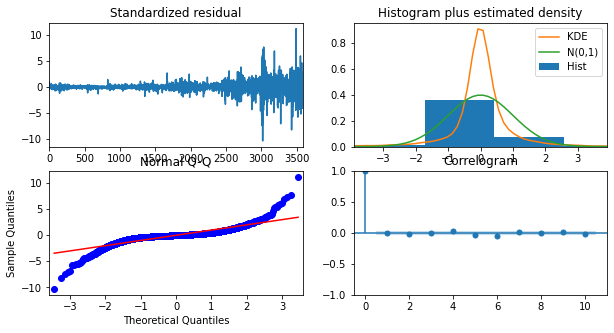

In [28]:
pmodel.plot_diagnostics(figsize=(10,5))
plt.show()

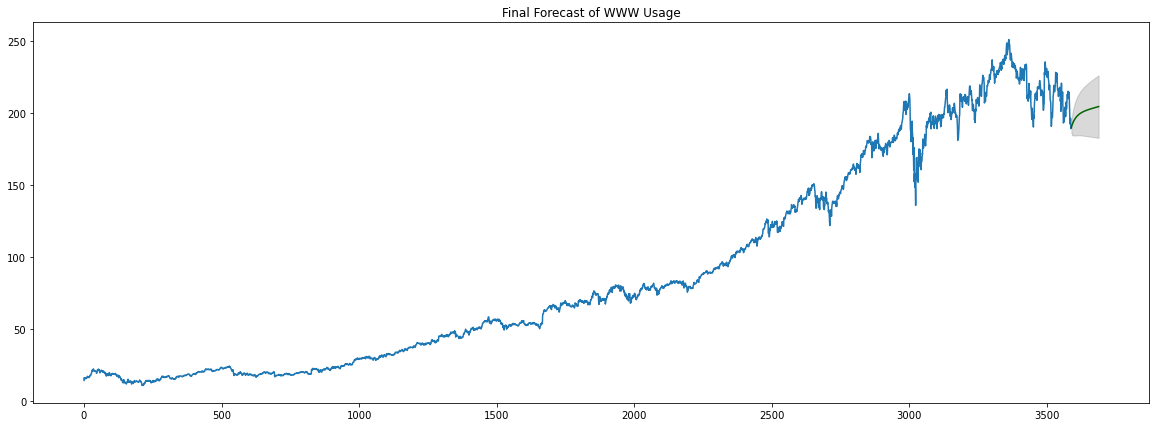

In [31]:
# Forecast
n_periods = 100
fc, confint = pmodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.close), len(df.close)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot

plt.figure(figsize=(20,7))
plt.plot(df.close.values)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()


In [ ]:
fc_series